![AES-CEE Masthead](http://kyrill.ias.sdsmt.edu/wjc/eduresources/AES_CEE_Masthead.png)
# USGS Data Retrieval Demonstration

This replicates an R Notebook that I've used in the past using a similar USGS package that reads from data from the [USGS National Water Information System (NWIS)](https://waterdata.usgs.gov/nwis), but adapted for Python.

## 1 Objectives

* Be able to read the daily mean streamflow from USGS for a given pre-identified gauge.
* Plot mean daily streamflow
* If needed, export data to an alternative text format (in this case, a comma-delimited (csv) file that MS Excel can read.

## 2 Libraries

This script uses the following libraries

The Basics...

* [numpy](https://numpy.org/): Python's "go-to" library for math and array/matrix structures
* [pandas](https://pandas.pydata.org/): A fast, powerful, flexible and easy to use open source data analysis and manipulation tool that has structures similar to R's "DataFrame"
* [matplotlib](https://matplotlib.org/stable/): Python's "go-to" Graphics Library.
* [seaborn](https://seaborn.pydata.org/): An extention to Pandas that includes resources for statistical graphical data

And more specialized libraries

* [dataretrieval](https://doi-usgs.github.io/dataretrieval-python/): A Python alternative to the USGS R data retrieval package to obtain USGS and EPA water quality data, streamflow data, and metadata directly from their web services portals.

* [itables](https://mwouts.github.io/itables/): A Juptyer extension that will allow your tables to be displayed in a manner similar to RStudio by which you can scroll through them.  If you have big or wide tables, this is what you need to explore your data.  Be aware that you should comment it out if you export your file into a plain *.py executable.  To activate, you must invoke the command, [itables.init_notebook_mode()](https://mwouts.github.io/itables/pandas_style.html)  

Non-Library iPython Resource...

* [version_information](https://github.com/jrjohansson/version_information): Package version documentation to aid in replicability. See its use at the bottom of this notebook.

See its use at the bottom of this notebook.  You will need to remove this before saving it as a plain Python "*.py" script.


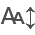

In [1]:
######################################################
#
# Libraries
#

import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import seaborn            as sns


import dataretrieval.nwis as nwis

# Load and *activate* the itables.init_notebook_mode()

from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

#
######################################################

## 3 A fast summary of the USGS National Water Information System (NWIS)

The USGS has an extensive set of datasets that can be accessed by the public through its web interfaces.  

However, people who want to forego web clicking and have a programming background may wish to dive directly into the raw data so they can repeatedly pull/analyze it.

Accessing data comes in three primary descriptors (apart from individual stations):

*  [Service](https://waterservices.usgs.gov/rest/Site-Service.html#outputDataTypeCd): Where things come from to delimit searches to daily obs, field campaigns, water quality data, etc.
*  [Parameters](https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes): The specific observation.
*  [Statistic](https://help.waterdata.usgs.gov/stat_code): How the data is aggregated (if at all).

### 3.1 Data Services List: *"DataTypeCd"*

The Data Type or Data Service access ["service" / "data type"] (https://waterservices.usgs.gov/rest/Site-Service.html#outputDataTypeCd) better direct your search.  In this example, we will be pulling daily aggregate values ("dv").

| Service Code | Description |
|:---:|:--------------|
| all | default (see above for qualifications).|
| iv  | Instantaneous values (time-series measurements typically recorded by automated equipment at frequent intervals (e.g., hourly)|
| uv  | Unit values **(alias for iv)**|
| rt  | Real-time data **(alias for iv)**. Note: use of rv does not restrict time-series data to only those with real-time data.|
| dv  | Daily values (once daily measurements or summarized information for a particular day, such as daily maximum, minimum and mean)|
| pk  | Peak measurements of water levels and streamflow for surface water sites (such as during floods, may be either an automated or a manual measurement)|
| sv  | Site visits (irregular manual surface water measurements, excluding peak measurements)|
| gw  | Groundwater levels measured at irregular, discrete intervals. For recorded, time series groundwater levels, use iv or id.|
| qw  | Water-quality data from discrete sampling events and analyzed in the field or in a laboratory. **For recorded time series water-quality data, use iv or id**. |
| id  | Historical instantaneous values (sites in the [USGS Instantaneous Data Archive](https://nwis.waterdata.usgs.gov/nwis) |
| aw  | Sites monitored by the [USGS Active Groundwater Level Network](http://groundwaterwatch.usgs.gov/) |
| ad  | Sites included in [USGS Annual Water Data Reports](https://wdr.water.usgs.gov) |

### 3.2 Data Parameter Code: *"parameterCd"*

Look over the [parameter lookup table](https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes) to see what we have much more data available than what is in this very non-exhaustive list!


| 5-digit USGS parameter code | USGS parameter group name | USGS parameter name | Substance Registry Services Name | Parameter units |
|:-----:|:--------:|:-------------------------------------------------------|:---------------------------------|:------:|
| 00010 | Physical | Temperature, water, degrees Celsius                    | Temperature, water               | ° C    |
| 00020	| Physical | Temperature, air, degrees Celsius	                    | Temperature, air, deg C          | ° C    |
| 00060	| Physical | Discharge, cubic feet per second	                    | Stream flow, mean. daily         | ft³/s  |
| 00061	| Physical | Discharge, instantaneous, cubic feet per second	    | Stream flow, instantaneous       | ft³/s  |
| 00065	| Physical | Gage height, feet	                                    | Height, gage                     | ft     |
| 00045	| Physical | Precipitation, total, inches	                        | Precipitation                    | in     |
| 00062	| Physical | Elevation of reservoir water surface above datum, feet	|                                  | ft     |
| 00067	| Physical | Tide stage code                                        | Tide stage                       | [*code*](https://help.waterdata.usgs.gov/code/fixed_parms_query?fmt=rdb&inline=true)   |
| 30209	| Physical | Discharge, instantaneous, cubic meters per second      | Stream flow, instantaneous       | m³/sec |
| 62623	| Physical | Tide stage, above datum, feet	                        | Tide stage                       | ft     |
| 80154 | Sediment | Suspended sediment concentration, milligrams per liter | Suspended sediment concentration | mg/l   |

### 3.3 Statistics Code: *"statCd"*

A fast commonly-used list of [stat](https://help.waterdata.usgs.gov/stat_code) codes is here

| Statistic type code | Statistic type name | Statistic Type Description |
|:-----:|:---------------:|:----------------------------------:|
| 00001 | Maximum	      |	Maximum Values                     |
| 00002 | Minimum	      |	Minimum Values                     |
| 00003 | Mean	          |	Mean Values                        |
| 00004 | AM	          |	Values Taken Between 0001 And 1200 |
| 00005 | PM	          |	Values Taken Between 1201 And 2400 |
| 00006 | Sum	          |	Summation Values                   |
| 00007 | Mode	          |	Modal Values                       |
| 00008 | Median	      |	Median Values                      |
| 00009 | Std	          |	Standard Deviation Values          |
| 00010 | Variance        |	Variance Values                    |
| 00011 | Instantaneous   |	Random Instantaneous Values        |
| 00012 | Equivalent Mean |	Equivalent Mean Values             |
| 00013 | Skewness        |	Skewness Values                    |
| 00021 | Tidal High-High |	Tidal High-High Values             |
| 00022 | Tidal Low-High  |	Tidal Low-High Values              |
| 00023 | Tidal High-Low  |	Tidal High-Low Values              |
| 00024 | Tidal Low-Low   |	Tidal Low-Low Values               |

### 3.4 Other Codes

Other applicable codes are either singling out specific stations or grouping areas so you can pull a number of stations. A larger list if search criteria can be found [*here*](https://waterservices.usgs.gov/docs/site-service/site-service-details/).  Common ones that I've used are... 

* **site**: Station ID Codes
* **startDt** & **endDt**: Start/End Dates (Format: YYYY-MM-DD)
* **siteStatus**: [Is the station active?](https://waterservices.usgs.gov/docs/site-service/site-service-details/#site-status-sitestatus)
* **siteType**: [Specific Station Type](https://help.waterdata.usgs.gov/site_tp_cd)
* **stateCd**: Group by State [2-Digit Abbreviation](https://faq.usps.com/s/article/What-are-the-USPS-abbreviations-for-U-S-states-and-territories)
* **countyCd**: [2-Digit FIPS State Code + 3-Digit County Code](https://help.waterdata.usgs.gov/code/county_query?fmt=html). For example. Pennington County, SD, is "countyCd" 46103
* **huc**: [Hydrologic Unit](https://water.usgs.gov/GIS/huc_name.html)

## 4 Example Pulling Data

This next section is a typical workflow I go through looking for data.

These are broken down into typical stages

* Get specific station information (in this case, I will be grabbing data from a given watershed)
  * [dataretrieval.nwis.get_info()](https://doi-usgs.github.io/dataretrieval-python/reference/nwis.html#dataretrieval.nwis.get_info)
* Pulling the Data
* Curating the Data

### 4.1 Fetching File Metadata

I prefer to get a table of station data even if I don't need it for data analysis since I already know what I want to pull (e.g., I already have the station id code, datatype, etc.).  Such data may be handy when making nice plots as one example.

In this scenario, I am going to look for streamflow data over Rapid Creek.

<div class="alert alert-info">
Be aware that this operation requires some interaction with the user. 
</div>


Here, I will use the following [search parameters.](https://waterservices.usgs.gov/docs/site-service/site-service-details/)  That said, the method I am using will not cast so fine as presented below.  

| NWIS Parameter | Value  | Plain Language Description |
|:-----------:|:----------:|:-------------------------:|
| dataTypeCd  | "dv"       | Daily Values              |
| siteType    | "ST"       | Stream Stations           |
| huc         | "10120110" | Rapid Creek HUC (Level 8) |
| parameterCd | "00060"    | Discharge in cfs          |
| statCd      | "00003"    | Mean                      |
|  |  To pull this information, I will get [dataretrieval.nwis.get_info()](https://doi-usgs.github.io/dataretrieval-python/reference/nwis.html#dataretrieval.nwis.get_info).

The output is in two parts.  The first is a Pandas Data Table. Is the URL sent into the NWS service to call the data.  You can try that on your own.  

Since I may want the dates of the available data, I will need to use the argument...

```
seriesCatalogOutput = True
```

The resulting search return will only include the stations meeting those requested criteria. *BUT* it will include an inventory of all observations from all datafeeds for that station, each on its own record. That will return a LOT of rows.  Even with our available restrictions, this will be more than the *itables* package can aford render in the Juptyer Notebook!

We will tighten our inventory in the next step, but below you will see me isolate unique records for counting purposes using [pandas.DataFrame.unique()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html).

In [2]:
######################################################
#
# Pulling Station Information
#

#
# Search Criteria
#

dataTypeCd  = 'dv'       # Daily Value Services (not accessible)
siteType    = "ST"       # Stream Stations
huc         = "10120110" # Rapid Creek HUC (Level 8)  
parameterCd = "00060"    # Discharge in cfs 
statCd      = "00003"    # Mean

#
# Pull the Data
#

info_df, info_url  = nwis.get_info(huc                 = huc,
                                   dataTypeCd          = dataTypeCd,
                                   parameterCd         = parameterCd,
                                   siteType            = siteType,
                                   seriesCatalogOutput = True)

#
# Do a fast review of the size of the DataFrame and any unique stations
#

print(" ")
print("        Total Number of Captured Records: ",len(info_df))
print("Total Number of Unique Captured Stations: ",len(info_df["station_nm"].unique()  ))

#
# Display the DataFrame
#

display(info_df)

#
######################################################

/opt/miniconda3/lib/python3.12/site-packages/dataretrieval/nwis.py:796: UserWarning: WARNING: Starting in March 2024, the NWIS qw data endpoint is retiring and no longer receives updates. For more information, refer to https://waterdata.usgs.gov.nwis/qwdata and https://doi-usgs.github.io/dataRetrieval/articles/Status.html or email CompTools@usgs.gov.
  warnings.warn(('WARNING: Starting in March 2024, the NWIS qw data endpoint is '


 
        Total Number of Captured Records:  3223
Total Number of Unique Captured Stations:  32


agency_cd   site_no                    station_nm site_tp_cd  dec_lat_va  \
0         USGS  06408700  RHOADS FORK NEAR ROCHFORD,SD         ST   44.133871   
1         USGS  06408700  RHOADS FORK NEAR ROCHFORD,SD         ST   44.133871   
2         USGS  06408700  RHOADS FORK NEAR ROCHFORD,SD         ST   44.133871   
3         USGS  06408700  RHOADS FORK NEAR ROCHFORD,SD         ST   44.133871   
4         USGS  06408700  RHOADS FORK NEAR ROCHFORD,SD         ST   44.133871   
...        ...       ...                           ...        ...         ...   
3218      USGS  06422000        RAPID CR AT CRESTON SD         ST   43.916655   
3219      USGS  06422000        RAPID CR AT CRESTON SD         ST   43.916655   
3220      USGS  06422000        RAPID CR AT CRESTON SD         ST   43.916655   
3221      USGS  06422000        RAPID CR AT CRESTON SD         ST   43.916655   
3222      USGS  06422000        RAPID CR AT CRESTON SD         ST   43.916655   

      dec_long_va coord_acy_cd dec_coord_datum_cd  alt_va  alt_acy_va  ...  \
0     -103.861591            M              NAD83  5991.2        10.0  ...   
1     -103.861591            M              NAD83  5991.2        10.0  ...   
2     -103.861591            M              NAD83  5991.2        10.0  ...   
3     -103.861591            M              NAD83  5991.2        10.0  ...   
4     -103.861591            M              NAD83  5991.2        10.0  ...   
...           ...          ...                ...     ...         ...  ...   
3218  -102.700451            M              NAD83  2520.0       111.0  ...   
3219  -102.700451            M              NAD83  2520.0       111.0  ...   
3220  -102.700451            M              NAD83  2520.0       111.0  ...   
3221  -102.700451            M              NAD83  2520.0       111.0  ...   
3222  -102.700451            M              NAD83  2520.0       111.0  ...   

       ts_id  loc_web_ds medium_grp_cd parm_grp_cd    srs_id  access_cd  \
0          0         NaN           wat         NaN         0          0   
1     128492         NaN           wat         NaN   1645423          0   
2     283819         NaN           wat         NaN  17164583          0   
3          0         NaN           wat         NaN         0          0   
4          0         NaN           wat         ALL         0          0   
...      ...         ...           ...         ...       ...        ...   
3218       0         NaN           wat         RAD    182451          0   
3219       0         NaN           wat         RAD    182469          0   
3220       0         NaN           wat         PHY   1646694          0   
3221       0         NaN           wat         INN   1640192          0   
3222       0         NaN           wat         NaN         0          0   

      begin_date    end_date count_nu                     geometry  
0           2006        2023       18  POINT (-103.86159 44.13387)  
1     1981-11-01  2024-10-21    15165  POINT (-103.86159 44.13387)  
2     2019-04-04  2024-10-21     2027  POINT (-103.86159 44.13387)  
3     1982-06-23  2023-08-04       41  POINT (-103.86159 44.13387)  
4     1978-01-01  2015-08-07      240  POINT (-103.86159 44.13387)  
...          ...         ...      ...                          ...  
3218  1989-12-04  1989-12-04        1  POINT (-102.70045 43.91666)  
3219  1989-12-04  1989-12-04        1  POINT (-102.70045 43.91666)  
3220  1989-12-04  1990-06-12        2  POINT (-102.70045 43.91666)  
3221  1989-12-04  1990-06-12        2  POINT (-102.70045 43.91666)  
3222  1989-07-31  2000-08-31       34  POINT (-102.70045 43.91666)  

[3223 rows x 25 columns]

That's 3223 different levels of data for all the available stations.

Again, even though we seem to have requested just the daily mean discharge, the ** gives you every available nugget of data on that menu. Presently, that is the only resource that gives us the time series.

We will only need the records corresponding to the fields we need. 

Here we will use just some basic [Panda-Fu](https://wesmckinney.com/book/pandas-basics#pandas_basic_indexing).  (Carefull, notice that it interpreted that "StatCd" as an integer!

!["Nobody says no to Panda"](http://kyrill.ias.sdsmt.edu/wjc/eduresources/angry-panda-office-gif.gif)

Also if you swipe to the far right side of the DataFrame you will see that there is geospatial metadata which means you can use the data with [GeoPandas](https://geopandas.org/en/stable/).

In [3]:
######################################################
#
# Select our specific parameter and its preferred aggregation
#

info_df = info_df[(info_df["parm_cd"] == parameterCd) & 
                  (info_df["stat_cd"] == int(statCd)) ]

#
# Display Limited Station Inventory
#

display(info_df)

#
######################################################

agency_cd   site_no                                         station_nm  \
1         USGS  06408700                       RHOADS FORK NEAR ROCHFORD,SD   
94        USGS  06408860                      RAPID CREEK NEAR ROCHFORD, SD   
186       USGS  06409000  CASTLE CREEK ABOVE DEERFIELD RES NEAR HILL CIT...   
551       USGS  06410000                CASTLE CREEK BELOW DEERFIELD DAM SD   
578       USGS  06410500  RAPID CREEK ABOVE PACTOLA RES AT SILVER CITY,  SD   
699       USGS  06411500                   RAPID CREEK BELOW PACTOLA DAM,SD   
855       USGS  06412200   RAPID CREEK ABV VICTORIA CREEK NR RAPID CITY, SD   
966       USGS  06412500     RAPID CREEK ABV CANYON LAKE NEAR RAPID CITY,SD   
1234      USGS  06412510                   RAPID CREEK ABOVE RAPID CITY, SD   
1245      USGS  06412600      CLEGHORN SPGS MAIN CH AT FISH HATCH AT RC, SD   
1299      USGS  06412700    CLEGHORN SPGS S CHANNEL AT FISH HATCH AT RC, SD   
1343      USGS  06412800    CLEGHORN SPGS N CHANNEL AT FISH HATCH AT RC, SD   
1388      USGS  06412810                 CLEGHORN SPRINGS AT RAPID CITY, SD   
1486      USGS  06412900     RAPID CREEK BLW CLEGHORN SPGS AT RAPID CITY SD   
1635      USGS  06413200      RAPID CREEK BELOW PARK DRIVE AT RAPID CITY SD   
1870      USGS  06413300   LEEDY DITCH AT HEADGATE BLW CLD AT RAPID CITY SD   
1880      USGS  06413550              LEEDY DITCH AT MOUTH AT RAPID CITY SD   
1890      USGS  06413570          RAPID C AB JACKSON BLVD AT RAPID CITY, SD   
1955      USGS  06413600                     CITY SPRINGS AT RAPID CITY, SD   
2008      USGS  06413650              LIME CREEK AT MOUTH AT RAPID CITY, SD   
2047      USGS  06413660       STORYBOOK DITCH AT HEADGATE AT RAPID CITY SD   
2057      USGS  06413670          STORYBOOK DITCH AT MOUTH AT RAPID CITY SD   
2067      USGS  06413700     RAPID CR AB WATER TREAT PLANT AT RAPID CITY SD   
2213      USGS  06413800       DEADWOOD AVE DRAIN AT MOUTH AT RAPID CITY SD   
2255      USGS  06414000                          RAPID CR AT RAPID CITY,SD   
2492      USGS  06414700          RAPID CR AT EAST MAIN ST AT RAPID CITY SD   
2597      USGS  06415500                    HAWTHORN DITCH AT RAPID CITY SD   
2606      USGS  06416300                MEADE STREET DRAIN AT RAPID CITY SD   
2834      USGS  06418800            RAPID CREEK ABOVE WRF NR RAPID CITY, SD   
2885      USGS  06418900  RAPID CR BL SEWAGE TREATMENT PL NR RAPID CITY, SD   
3007      USGS  06421500                       RAPID CR NEAR FARMINGDALE,SD   
3144      USGS  06422000                             RAPID CR AT CRESTON SD   

     site_tp_cd  dec_lat_va  dec_long_va coord_acy_cd dec_coord_datum_cd  \
1            ST   44.133871  -103.861591            M              NAD83   
94           ST   44.104707  -103.643528            M              NAD83   
186          ST   44.013592  -103.830478            M              NAD83   
551          ST   44.029148  -103.781865            M              NAD83   
578          ST   44.084708  -103.580470            M              NAD83   
699          ST   44.076654  -103.482134            M              NAD83   
855          ST   44.046599  -103.351574            M              NAD83   
966          ST   44.052766  -103.311851            M              NAD83   
1234         ST   44.052766  -103.311851            M              NAD83   
1245         ST   44.058877  -103.298795            M              NAD83   
1299         ST   44.058599  -103.299350            M              NAD83   
1343         ST   44.058877  -103.298795            M              NAD83   
1388         ST   44.058877  -103.297406            M              NAD83   
1486         ST   44.059154  -103.297406            M              NAD83   
1635         ST   44.059154  -103.284350            M              NAD83   
1870         ST   44.057488  -103.287128            M              NAD83   
1880         ST   44.063599  -103.273238            M              NAD83   
1890         ST   44.065266  

### 4.2 Extracting the Data

With that we can now extract the data.

Here we will use a specialized package [dataretrieval.nwis.get_dv()](https://doi-usgs.github.io/dataretrieval-python/reference/nwis.html#dataretrieval.nwis.get_dv) which focuses on pulling data from the "Daily Values" service.

From the above refined list, you can select a single station (I have the [Rapid Creek gage across from Office Depot](https://waterdata.usgs.gov/monitoring-location/06414000/) commented out), or you can use all of them at once.  I'm doing it all at once for now.

In either case, you will need to select the start and end period. Since we extracted the "BIG" inventory, we have that information already.

This is done with some more Pandas Manipulation.



#### 4.2.1 Doing this with ONE datapoint

We can start with one single datapoint, here I am assuming that we have identified the one station that we want.  As shown above in this scenario it's gage 06414000, or as humans call it "Rapid Creek at Rapid City" (nice helpful name, boyz).  


In [4]:
######################################################
#
# Pulling Single Station Data Information
#

#
# Site Selection
#

info_single_df = info_df[ (info_df["station_nm"] == "RAPID CR AT RAPID CITY,SD") ]

display(info_single_df)

siteNumbers = info_single_df["site_no"].to_list()

print("SiteNumber List:", siteNumbers)

#
# Extracting Data Ranges for the requested station(s).
#

start_date = info_single_df["begin_date"].to_numpy().min()
end_date   = info_single_df[  "end_date"].to_numpy().max()

print("processing dates from " + start_date + " to " + end_date)

#
# Extracting the Data for the requested station(s).
#

dv_single_df, dv_single_url = nwis.get_dv(sites       = siteNumbers, 
                                          parameterCd = parameterCd,
                                          statCd      =      statCd,
                                          start       =  start_date,
                                          end         =    end_date)

#
# Display Full Extracted Record
#

display(dv_single_df)

#
######################################################

agency_cd   site_no                 station_nm site_tp_cd  dec_lat_va  \
2255      USGS  06414000  RAPID CR AT RAPID CITY,SD         ST   44.085516   

      dec_long_va coord_acy_cd dec_coord_datum_cd   alt_va  alt_acy_va  ...  \
2255  -103.241843            M              NAD83  3231.68        0.01  ...   

       ts_id  loc_web_ds medium_grp_cd parm_grp_cd   srs_id  access_cd  \
2255  128516         NaN           wat         NaN  1645423          0   

      begin_date    end_date count_nu                     geometry  
2255  1942-07-01  2024-10-21    30064  POINT (-103.24184 44.08552)  

[1 rows x 25 columns]

SiteNumber List: ['06414000']
processing dates from 1942-07-01 to 2024-10-21


site_no  00060_Mean 00060_Mean_cd
datetime                                                     
1942-07-01 00:00:00+00:00  06414000       126.0             A
1942-07-02 00:00:00+00:00  06414000       122.0             A
1942-07-03 00:00:00+00:00  06414000       118.0             A
1942-07-04 00:00:00+00:00  06414000       104.0             A
1942-07-05 00:00:00+00:00  06414000        97.0             A
...                             ...         ...           ...
2024-10-17 00:00:00+00:00  06414000        48.2             P
2024-10-18 00:00:00+00:00  06414000        50.1             P
2024-10-19 00:00:00+00:00  06414000        52.2             P
2024-10-20 00:00:00+00:00  06414000        52.7             P
2024-10-21 00:00:00+00:00  06414000        52.2             P

[30064 rows x 3 columns]

For some housekeeping we can drop the qualify flags (with [pandas.DataFrame.drop()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)) and also change the name of the data column (with [pandas.DataFrame.drop()](https://pandas.pydata.org/pandas-docs/stable/https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)) since the USGS codes are not intuitive.

And then we can display the data and since there is only one value of "site_no," Pandas can plot the data with little drama with [pandas.DataFrame.plot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html). (For the multiple station dataset we will have to add some steps).

And yes, that's the Rapid City Flood in 1972!

site_no  Discharge_cfs
datetime                                          
1942-07-01 00:00:00+00:00  06414000          126.0
1942-07-02 00:00:00+00:00  06414000          122.0
1942-07-03 00:00:00+00:00  06414000          118.0
1942-07-04 00:00:00+00:00  06414000          104.0
1942-07-05 00:00:00+00:00  06414000           97.0
...                             ...            ...
2024-10-17 00:00:00+00:00  06414000           48.2
2024-10-18 00:00:00+00:00  06414000           50.1
2024-10-19 00:00:00+00:00  06414000           52.2
2024-10-20 00:00:00+00:00  06414000           52.7
2024-10-21 00:00:00+00:00  06414000           52.2

[30064 rows x 2 columns]

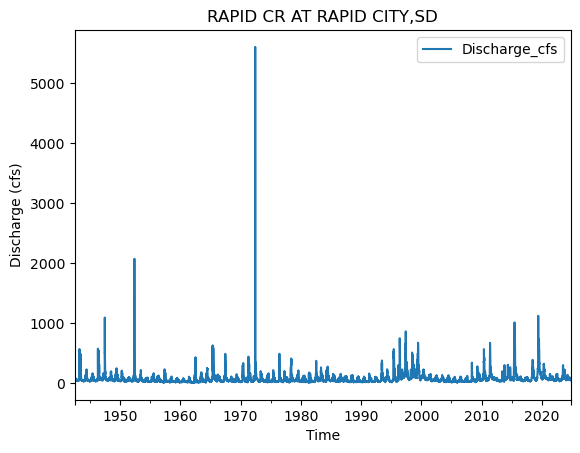

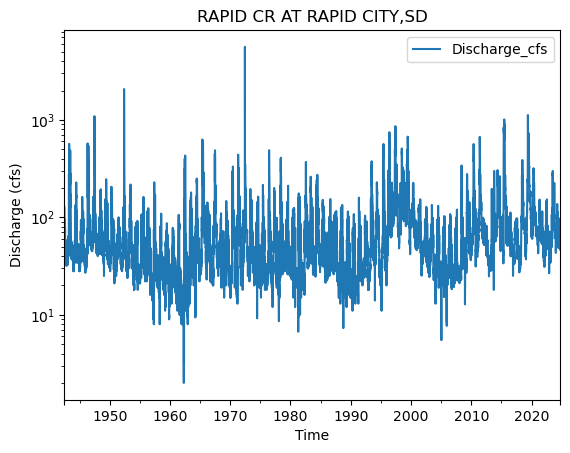

In [5]:
######################################################
#
# Tidy up the Columns
#

#
# Drop Quality Flag Column
#

discharge_single = dv_single_df.drop(labels = ["00060_Mean_cd"],
                                     axis   =         "columns")

#
# Rename Columns
#

discharge_single = discharge_single.rename(columns={"00060_Mean": "Discharge_cfs"})

#
# Display The Rest of the Data
#

display(discharge_single)

#
# Plot a simple time series
#

discharge_single.plot()
plt.title( info_single_df["station_nm"].values[0] ) 
plt.xlabel( "Time" )
plt.ylabel( "Discharge (cfs)" )
plt.show()

#

discharge_single.plot()
plt.title( info_single_df["station_nm"].values[0] )
plt.xlabel( "Time" )
plt.ylabel( "Discharge (cfs)" )
plt.yscale( value = "log" )
plt.show()

#
######################################################

#### 4.2.2 Working with Multiple Stations at Once

The dataretrieval package lets you pull multiple stations at once.

The procedure to pull the data into a DataFrame is the same as doing it for one station.

Let's take the original inventory and repeat the same procedures up to where we get the DataFrame.

In [ ]:
######################################################
#
# Pulling Multiple Station Data Information
#

#
# Site Selection
#

info_multi_df = info_df

display(info_multi_df)

siteNumbers = info_multi_df["site_no"].to_list()

print("SiteNumber List:", siteNumbers)

#
# Extracting Data Ranges for the requested station(s).
#

start_date = info_multi_df["begin_date"].to_numpy().min()
end_date   = info_multi_df[  "end_date"].to_numpy().max()

print("processing dates from " + start_date + " to " + end_date)

#
# Extracting the Data for the requested station(s).
#

dv_multi_df, dv_multi_url = nwis.get_dv(sites       = siteNumbers, 
                                        parameterCd = parameterCd,
                                        statCd      =     '00003',
                                        start       =  start_date,
                                        end         =    end_date)

#
# Drop Quality Flag Column
#

discharge_multi = dv_multi_df.drop(labels = ["00060_Mean_cd"],
                                    axis   =         "columns")

#
# Rename Columns
#

discharge_multi = discharge_multi.rename(columns={"00060_Mean": "Discharge_cfs"})

#
# Display The Rest of the Data
#

display(discharge_multi)

#
######################################################

agency_cd   site_no                                         station_nm  \
1         USGS  06408700                       RHOADS FORK NEAR ROCHFORD,SD   
94        USGS  06408860                      RAPID CREEK NEAR ROCHFORD, SD   
186       USGS  06409000  CASTLE CREEK ABOVE DEERFIELD RES NEAR HILL CIT...   
551       USGS  06410000                CASTLE CREEK BELOW DEERFIELD DAM SD   
578       USGS  06410500  RAPID CREEK ABOVE PACTOLA RES AT SILVER CITY,  SD   
699       USGS  06411500                   RAPID CREEK BELOW PACTOLA DAM,SD   
855       USGS  06412200   RAPID CREEK ABV VICTORIA CREEK NR RAPID CITY, SD   
966       USGS  06412500     RAPID CREEK ABV CANYON LAKE NEAR RAPID CITY,SD   
1234      USGS  06412510                   RAPID CREEK ABOVE RAPID CITY, SD   
1245      USGS  06412600      CLEGHORN SPGS MAIN CH AT FISH HATCH AT RC, SD   
1299      USGS  06412700    CLEGHORN SPGS S CHANNEL AT FISH HATCH AT RC, SD   
1343      USGS  06412800    CLEGHORN SPGS N CHANNEL AT FISH HATCH AT RC, SD   
1388      USGS  06412810                 CLEGHORN SPRINGS AT RAPID CITY, SD   
1486      USGS  06412900     RAPID CREEK BLW CLEGHORN SPGS AT RAPID CITY SD   
1635      USGS  06413200      RAPID CREEK BELOW PARK DRIVE AT RAPID CITY SD   
1870      USGS  06413300   LEEDY DITCH AT HEADGATE BLW CLD AT RAPID CITY SD   
1880      USGS  06413550              LEEDY DITCH AT MOUTH AT RAPID CITY SD   
1890      USGS  06413570          RAPID C AB JACKSON BLVD AT RAPID CITY, SD   
1955      USGS  06413600                     CITY SPRINGS AT RAPID CITY, SD   
2008      USGS  06413650              LIME CREEK AT MOUTH AT RAPID CITY, SD   
2047      USGS  06413660       STORYBOOK DITCH AT HEADGATE AT RAPID CITY SD   
2057      USGS  06413670          STORYBOOK DITCH AT MOUTH AT RAPID CITY SD   
2067      USGS  06413700     RAPID CR AB WATER TREAT PLANT AT RAPID CITY SD   
2213      USGS  06413800       DEADWOOD AVE DRAIN AT MOUTH AT RAPID CITY SD   
2255      USGS  06414000                          RAPID CR AT RAPID CITY,SD   
2492      USGS  06414700          RAPID CR AT EAST MAIN ST AT RAPID CITY SD   
2597      USGS  06415500                    HAWTHORN DITCH AT RAPID CITY SD   
2606      USGS  06416300                MEADE STREET DRAIN AT RAPID CITY SD   
2834      USGS  06418800            RAPID CREEK ABOVE WRF NR RAPID CITY, SD   
2885      USGS  06418900  RAPID CR BL SEWAGE TREATMENT PL NR RAPID CITY, SD   
3007      USGS  06421500                       RAPID CR NEAR FARMINGDALE,SD   
3144      USGS  06422000                             RAPID CR AT CRESTON SD   

     site_tp_cd  dec_lat_va  dec_long_va coord_acy_cd dec_coord_datum_cd  \
1            ST   44.133871  -103.861591            M              NAD83   
94           ST   44.104707  -103.643528            M              NAD83   
186          ST   44.013592  -103.830478            M              NAD83   
551          ST   44.029148  -103.781865            M              NAD83   
578          ST   44.084708  -103.580470            M              NAD83   
699          ST   44.076654  -103.482134            M              NAD83   
855          ST   44.046599  -103.351574            M              NAD83   
966          ST   44.052766  -103.311851            M              NAD83   
1234         ST   44.052766  -103.311851            M              NAD83   
1245         ST   44.058877  -103.298795            M              NAD83   
1299         ST   44.058599  -103.299350            M              NAD83   
1343         ST   44.058877  -103.298795            M              NAD83   
1388         ST   44.058877  -103.297406            M              NAD83   
1486         ST   44.059154  -103.297406            M              NAD83   
1635         ST   44.059154  -103.284350            M              NAD83   
1870         ST   44.057488  -103.287128            M              NAD83   
1880         ST   44.063599  -103.273238            M              NAD83   
1890         ST   44.065266  

SiteNumber List: ['06408700', '06408860', '06409000', '06410000', '06410500', '06411500', '06412200', '06412500', '06412510', '06412600', '06412700', '06412800', '06412810', '06412900', '06413200', '06413300', '06413550', '06413570', '06413600', '06413650', '06413660', '06413670', '06413700', '06413800', '06414000', '06414700', '06415500', '06416300', '06418800', '06418900', '06421500', '06422000']
processing dates from 1929-04-22 to 2024-10-21


### 4.3 Rabit Hole:  Pivoting DataFrames

Compare this DataFrame against the one with the single station.  Specifically, look at how Time Index is joined on the left by the *site_no* which now presents itself as its own index.  

If we plot this DataFrame as-is, the the graph will look awful since the x-axis, which defaults to the index (or in this case *indicies* will not play well.

The least costly way to process this data for plotting will be to "pivot" the dataset.

With this "Pivot" we can take one column (or in this case, co-index), and spread the unique values into multiple columns.  

![Pivoting from Long to Wide](https://pandas.pydata.org/docs/_images/reshaping_pivot.png)

Pivoting is discussed in detail [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html).

The procedure to do this is [pandas.DataFrame.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html), and is demonstrated here.

Should one station have more records than another, the while time series will be "pivoted," and stations that don't have data on a given day will be assigned NaN values.

In [ ]:
######################################################
#
# Pivoting from Long-to-Wide
#

discharge_multi_pivot = discharge_multi.pivot_table(index   =      "datetime",
                                                    columns =       "site_no",
                                                    values  = "Discharge_cfs")

#
# Display pivotted dataframe
#

display(discharge_multi_pivot)

#
# Plot the dataframe with the defalt Pandas Settings
#

#
# Plot a multiple time series
#

discharge_multi_pivot.plot(linewidth  = 0.1)
plt.title( "Rapid Creek" ) 
plt.xlabel( "Time" )
plt.ylabel( "Discharge (cfs)" )
plt.show()

#

discharge_multi_pivot.plot(linewidth  = 0.1)
plt.title( "Rapid Creek" ) 
plt.xlabel( "Time" )
plt.ylabel( "Discharge (cfs)" )
plt.yscale( value = "log" )
plt.show()

#
######################################################

Clearly this is not an ideal example of leveraging the plotting.  A fewer number of stations (and thus, columns) would be a better choice.

#### 4.4 Filling Missing Records

It's not uncommon for some datasets to have missing data from a continuous series but archived without missing records.  Unless a given station is truly physically interrupted for an extended period, USGS stream data doesn't have much of a problem here with their gauge data.

But since this is happening with other datasets, let's review what to do when this happens.

You can fill the gaps in the records with the [pandas.DataFrame.resample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) to create the framework for regular resampling which you then pass into the [resource](https://pandas.pydata.org/docs/reference/api/pandas.core.resample.Resampler.nearest.html#pandas.core.resample.Resampler.nearest).  Nearest neighbor will fill the gaps with the closest value.  To limit nearest neighbor you can set a "*limit*" of how far a "missing" record can be from a populated record. Beyond that the value will be set to a NaN value.  For us that is any new recoeds added making the limit = 1.

Note that in these cases we have no missing data to remove.  It just so happens that the selected stations are either continuous or, once the data is provided, all the continuous days have at least one record.

In [ ]:
######################################################
#
# Filling record gaps with missing data
#

discharge_multi_pivot_resampled = discharge_multi_pivot.resample('1D').nearest(limit=1)

discharge_single_resampled = discharge_single.resample('1D').nearest(limit=1)

print(" Milti Pivot Size", len(discharge_multi_pivot_resampled), len(discharge_multi_pivot_resampled))
print("Single Pivot Size", len(discharge_single), len(discharge_single_resampled))

#
# Plot resulting data.
#

discharge_single_resampled.plot(linewidth  = 0.5)
plt.title( info_single_df["station_nm"].values[0] )
plt.xlabel( "Time" )
plt.ylabel( "Discharge (cfs)" )
plt.yscale( value = "log" )
plt.show()


discharge_multi_pivot_resampled.plot(linewidth  = 0.1)
plt.title( "Rapid Creek" ) 
plt.xlabel( "Time" )
plt.ylabel( "Discharge (cfs)" )
plt.yscale( value = "log" )
plt.show()


#
######################################################

# 5 Saving as a CSV

At this point the way-forward is up to the user.

If you need to export your data to another format there are a number of them that you can send your Dataframe off to.  [The available external formats are discussed here.](https://pandas.pydata.org/docs/reference/io.html).

The most likely candidate for export for general use would be to send it a basic comma-delimited text file (a "CSV").  

This can be done easily with [pandas.DataFrame.to_csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) as demonstrated here.  In a Jupyter notebook the output directlry defaults to the current directory unless you provide an explicit directory path.

Since we are using time, it's best to select a format easy or external software to parse even though every good piece of software should be able to manage ISO-8601, you probably should send the time data to a format like "%y-%m-%d %H:%M:%S" (good old slow-to-fast).  

In [ ]:
######################################################
#
# Sending your output to a CSV File
#

csv_filename = "./HUC-" + huc + "_discharge.csv"

discharge_multi_pivot_resampled.to_csv(path_or_buf = csv_filename,
                                       date_format = "%Y-%m-%d %H:%M:%S")

#
######################################################

# 6 Version Information

*Version Information* is a package developed by J.R. Johansson and operates as what the iPython/Jupyter Environments calls ["Magic Line" commands](https://jakevdp.github.io/PythonDataScienceHandbook/01.03-magic-commands.html) which are invoked by a "%."  This one is convenient since it displays detailed information on the versions of Python, Jupyter, and any other denoted packages (but for those, you DO need to delete them since this is running "outside" of your notebook program.

The output will be in JSON format in the Jupyter Lab Notebook, but it will be a professional-looking table when rendered as an HTML file.

In [ ]:
################################################################
#
# Loading Version Information
#

%load_ext version_information
%version_information numpy, matplotlib, pandas, itables, dataretrieval, version_information

#
################################################################